# Foraging locust with dynamical systems (data)


In this notebook we use the `LocustDS` class to validate the dynamical systems modeling technique with respect to a training data. Conceptually, we train the same model on different time windows (specifiec by `start` time and `diffs` (duration),  both in tens of seconds.) Then, we evaluate them with respect to the same time windows, but using the validation dataset.

The model samples and the results are now saved. The user is welcome to re-run the validation by setting `force=True` and automatically save the resulting samples by setting `save=True` in the `run.inference()` and `.validate()` methods. 

The posterior predictive check and validation results are then plotted against (1) start time, and the intuition is that performance should not differ depending on at which point the time window starts, and (2) duration in seconds, and here it turns out that the dynamical systems display decent performance for predicting the flux of locusts for time windows shorter than 150 seconds, reaching performance comparable with that of the null model for longer periods. As mean absolute errors are easier to interpret, we also plot these against duration both for the training and the validation datasets.

In [1]:
import os

import dill
import matplotlib.pyplot as plt
import pandas as pd
import pyro
import seaborn as sns

pyro.settings.set(module_local_params=True)

sns.set_style("white")

# Set seed for reproducibility
seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)

import matplotlib.pyplot as plt
import seaborn as sns

from collab.foraging import locust as lc
from collab.utils import find_repo_root

root = find_repo_root()

smoke_test = "CI" in os.environ
num_iterations = 50 if smoke_test else 1500
num_samples = 20 if smoke_test else 150
starts = [0] if smoke_test else [0, 30, 60, 90]
diffs = [4] if smoke_test else [2, 3, 5, 7, 10, 13, 16, 20, 30, 40, 50, 60]

In [2]:
# if the user does not have the samples locally
# the first run will generate
# and save them if save is set to True in appropriate places

data_code = "15EQ20191202"
validation_data_code = "15EQ20191205"

init_ts = []
end_ts = []
null_maes = []
model_maes = []
rsquareds = []

v_null_maes = []
v_model_maes = []
v_rsquareds = []

for start in starts:
    for end in [start + diff for diff in diffs]:
        init_ts.append(start)
        end_ts.append(end)

        print(start, end)

        locds = lc.LocustDS(
            data_code=data_code,
            start=start,
            end=end,
        )

        locds.run_inference(
            "length",
            num_iterations=num_iterations,
            num_samples=num_samples,
            #    force=True, save=True
            # uncomment the above to generate the samples anew and save them
        )

        for key in locds.init_state.keys():
            assert (
                locds.init_state[key].item() == locds.samples[key][0, 0, 0].item()
            ), "predictive inits are wrong"

        locds.evaluate(
            samples=locds.samples,
            subset=locds.subset,
            figure=False,
            # can be used to plot the posterior predictive check
        )

        null_maes.append(locds.null_mae)
        model_maes.append(locds.mae)
        rsquareds.append(locds.rsquared)

        # uncomment for posterior predicive plots
        # if not smoke_test:
        #     locds.posterior_check()

        locds.validate(
            validation_data_code=validation_data_code,
            #               force = True, save=True
            figure=False,
        )
        # same here for validation

        for key in locds.v_init_state.keys():
            assert (
                locds.v_init_state[key].item() == locds.v_samples[key][0, 0, 0].item()
            ), "validation inits are wrong"
        # check if the right initial states are used
        # with the right samples
        # if you see this error, it's likely that the samples are not saved or loaded correctly
        # re-run validation with force=True (and save=True, if you wish to save the samples)

        v_null_maes.append(locds.validation[validation_data_code]["null_mae"])
        v_model_maes.append(locds.validation[validation_data_code]["mae"])
        v_rsquareds.append(locds.validation[validation_data_code]["rsquared"])

        # uncomment if you want to plot the posterior validation plots
        # one by one
        # if not smoke_test:
        #     locds.posterior_check(
        #         samples=locds.v_samples,
        #         subset=locds.v_subset,
        #         title=f"Validation ({start * 10} to {end * 10})",
        #     )

0 2
Loading inference samples
Loading validation samples
0 3
Loading inference samples
Loading validation samples
0 5
Loading inference samples
Loading validation samples
0 7
Loading inference samples
Loading validation samples
0 10
Loading inference samples
Loading validation samples
0 13
Loading inference samples
Loading validation samples
0 16
Loading inference samples
Loading validation samples
0 20
Loading inference samples
Loading validation samples
0 30
Loading inference samples
Loading validation samples
0 40
Loading inference samples
Loading validation samples
0 50
Loading inference samples
Loading validation samples
0 60
Loading inference samples
Loading validation samples
30 32
Loading inference samples
Loading validation samples
30 33
Loading inference samples
Loading validation samples
30 35
Loading inference samples
Loading validation samples
30 37
Loading inference samples
Loading validation samples
30 40
Loading inference samples
Loading validation samples
30 43
Loading

In [4]:
# put all the predictive check and validation results in data frames

# use date in the file path
# to avoid overwriting previous validation results
# as they require a lot of computation
from datetime import datetime

today = datetime.today().strftime("%Y-%m-%d")

root = find_repo_root()

results_path = os.path.join(
    root, f"data/foraging/locust/ds/length_experiment_results_{data_code}_{today}.pkl"
)

v_results_path = os.path.join(
    root,
    f"data/foraging/locust/ds/length_experiment_v_results_{data_code}_v{validation_data_code}_{today}.pkl",
)

if os.path.exists(results_path):
    with open(results_path, "rb") as f:
        results = dill.load(f)

else:
    results = pd.DataFrame(
        {
            "start": [_ * 10 for _ in init_ts],  # [:-1],
            "end": [_ * 10 for _ in end_ts],  # [:-1],
            "null_mae": null_maes,
            "model_mae": model_maes,
            "rsquared": rsquareds,
        }
    )

    results["duration"] = [_ * 1 for _ in (results["end"] - results["start"])]

    with open(results_path, "wb") as f:
        dill.dump(results, f)


if os.path.exists(v_results_path):
    with open(v_results_path, "rb") as f:
        v_results = dill.load(f)

else:
    v_results = pd.DataFrame(
        {
            "start": [_ * 10 for _ in init_ts],
            "end": [_ * 10 for _ in end_ts],
            "v_null_mae": v_null_maes,
            "v_model_mae": v_model_maes,
            "v_rsquared": v_rsquareds,
        }
    )

    v_results["duration"] = [_ * 1 for _ in (v_results["end"] - v_results["start"])]

    with open(v_results_path, "wb") as f:
        dill.dump(v_results, f)

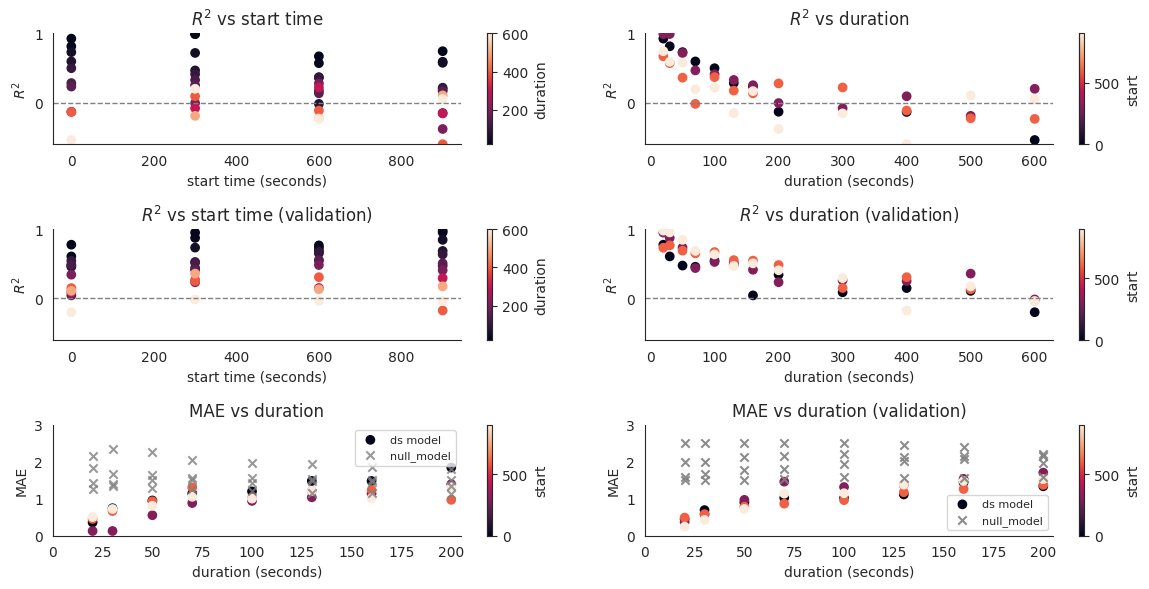

In [22]:
plt.figure(figsize=(12, 6))

plt.subplot(3, 2, 1)
scatter = plt.scatter(
    results["start"], results["rsquared"], marker="o", c=results["duration"]
)
plt.axhline(y=0, color="gray", linestyle="--", linewidth=1)
cbar = plt.colorbar(scatter, label="duration")
plt.xlabel("start time (seconds)")
plt.ylabel("$R^2$")
plt.ylim(-0.6, 1)
plt.title("$R^2$ vs start time")
sns.despine()


plt.subplot(3, 2, 2)
scatter2 = plt.scatter(
    results["duration"], results["rsquared"], marker="o", c=results["start"]
)
plt.axhline(y=0, color="gray", linestyle="--", linewidth=1)
cbar = plt.colorbar(scatter2, label="start")
plt.xlabel("duration (seconds)")
plt.ylabel("$R^2$")
plt.ylim(-0.6, 1)
plt.title("$R^2$ vs duration")
sns.despine()

plt.subplot(3, 2, 3)
scatter = plt.scatter(
    v_results["start"], v_results["v_rsquared"], marker="o", c=v_results["duration"]
)
plt.axhline(y=0, color="gray", linestyle="--", linewidth=1)
cbar = plt.colorbar(scatter, label="duration")
plt.xlabel("start time (seconds)")
plt.ylabel("$R^2$")
plt.ylim(-0.6, 1)
plt.title("$R^2$ vs start time (validation)")
sns.despine()

plt.subplot(3, 2, 4)
scatter2 = plt.scatter(
    v_results["duration"], v_results["v_rsquared"], marker="o", c=v_results["start"]
)
plt.axhline(y=0, color="gray", linestyle="--", linewidth=1)
cbar = plt.colorbar(scatter2, label="start")
plt.xlabel("duration (seconds)")
plt.ylabel("$R^2$")
plt.ylim(-0.6, 1)
plt.title("$R^2$ vs duration (validation)")
sns.despine()


plt.subplot(3, 2, 5)
scatter3 = plt.scatter(
    results["duration"],
    results["model_mae"],
    marker="o",
    c=results["start"],
    label="ds model",
)

plt.scatter(
    results["duration"],
    results["null_mae"],
    marker="x",
    c="gray",
    alpha=0.8,
    label="null_model",
)


# plt.axhline(y=0, color="gray", linestyle="--", linewidth=1)
cbar = plt.colorbar(scatter3, label="start")
plt.xlabel("duration (seconds)")
plt.ylabel("MAE")
plt.ylim(0, 3)
plt.xlim(0, 205)
plt.title("MAE vs duration")
plt.legend(prop={"size": 8})
sns.despine()


plt.subplot(3, 2, 6)
scatter4 = plt.scatter(
    v_results["duration"],
    v_results["v_model_mae"],
    marker="o",
    c=v_results["start"],
    label="ds model",
)

plt.scatter(
    v_results["duration"],
    v_results["v_null_mae"],
    marker="x",
    c="gray",
    alpha=0.9,
    label="null_model",
)


# plt.axhline(y=0, color="gray", linestyle="--", linewidth=1)
cbar = plt.colorbar(scatter4, label="start")
plt.xlabel("duration (seconds)")
plt.ylabel("MAE")
plt.ylim(0, 3)
plt.xlim(0, 205)
plt.legend(prop={"size": 8})
plt.title("MAE vs duration (validation)")
sns.despine()


plt.tight_layout()
if not smoke_test:
    plt.savefig(os.path.join(root, "docs/figures/locust_ds_validation.png"))
plt.show()

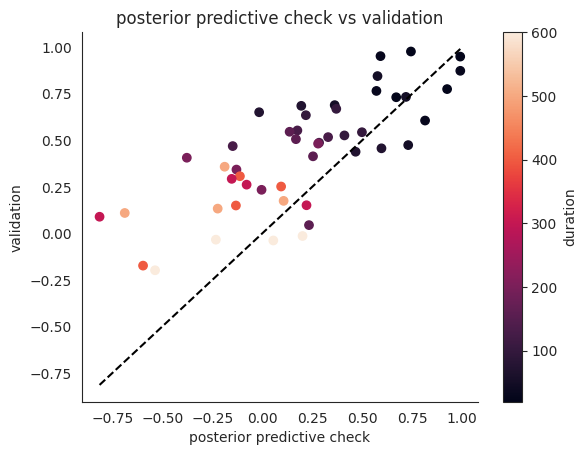

In [23]:
# note validation performance is slightly better, esp. for longer durations
# conjecture: the model slightly overfits early data and so loses performance esp. for longer durations

scatter = plt.scatter(
    y=v_results["v_rsquared"],
    x=results["rsquared"],
    marker="o",
    c=v_results["duration"],
)
plt.plot(
    [results["rsquared"].min(), results["rsquared"].max()],
    [results["rsquared"].min(), results["rsquared"].max()],
    color="black",
    linestyle="--",
)

plt.title("posterior predictive check vs validation")
plt.xlabel("posterior predictive check")
plt.ylabel("validation")
sns.despine()
plt.colorbar(scatter, label="duration")
plt.show()